In [ ]:
pip install pydicom

In [ ]:
%tensorflow_version 1.x
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/My Drive/covid-19/penomina

/content/drive/My Drive/covid-19/penomina


In [ ]:
DATA_DIR = '/content/drive/My Drive/covid-19/penomina'
# Directory to save logs and trained model
ROOT_DIR = '/content/drive/My Drive/covid-19/Results'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [ ]:
#Import Mask RCNN
#sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
!pip install mrcnn
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')

### Download COCO pre-trained weights

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [ ]:
import os.path
from os import path
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    i=0
    image_fps1=[]
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        if path.exists(fp):
          image_annotations[fp].append(row)
          image_fps1.append(fp)
        else:
          print("skipped ",i, "-", row['patientId'])
          i=i+1          
    return image_fps1, image_annotations 

In [ ]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
pwd

'/content/drive/My Drive/covid-19/penomina'

In [ ]:
!ls /content/drive/My\ Drive/covid-19/penomina/stage_2_train_images/*.dcm | wc -l 

4809


### Examine the annotation data, parse the dataset, and view dicom fields

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,Unnamed: 0,patientId,class,x,y,width,height,Target
0,0,3be6a4c5-7c20-48cf-ae13-e18a828b3868,Lung Opacity,277.0,534.0,124.0,263.0,1
1,1,3be6a4c5-7c20-48cf-ae13-e18a828b3868,Lung Opacity,527.0,496.0,157.0,302.0,1
2,2,39ccfb59-c36e-42d1-94eb-5186759d33e0,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,3,345d4363-a4e6-47f4-97c8-9bbd22061ae9,Lung Opacity,231.0,506.0,125.0,173.0,1
4,4,345d4363-a4e6-47f4-97c8-9bbd22061ae9,Lung Opacity,489.0,342.0,196.0,328.0,1


In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

skipped  0 - 78c33a1a-8f22-476c-ae97-8190192102df
skipped  1 - 78c33a1a-8f22-476c-ae97-8190192102df
skipped  2 - 73d61c35-605f-435e-af98-5cc68b188a46
skipped  3 - 73d61c35-605f-435e-af98-5cc68b188a46
skipped  4 - 734b9290-8d34-4d42-9d2b-1b3bdb98c373
skipped  5 - 734b9290-8d34-4d42-9d2b-1b3bdb98c373
skipped  6 - 78834a4d-5eae-48bb-a7c2-77c17d3f2ab5
skipped  7 - 793a56ab-71fd-4bce-b9fe-d25c63d93459
skipped  8 - 7469db63-0c15-4e73-b6c4-9df8c2b9dd6c
skipped  9 - 7834a7b0-6064-4f9c-bf5c-a526393af472
skipped  10 - 7834a7b0-6064-4f9c-bf5c-a526393af472
skipped  11 - 76f71a93-8105-4c79-a010-0cfa86f0061a
skipped  12 - 76f71a93-8105-4c79-a010-0cfa86f0061a
skipped  13 - 76f71a93-8105-4c79-a010-0cfa86f0061a
skipped  14 - 76f71a93-8105-4c79-a010-0cfa86f0061a
skipped  15 - 750d6b01-4273-43b2-8de8-500e738cb257
skipped  16 - 79bb5ea3-ca6c-4d75-a379-a6ee6c6da659
skipped  17 - 7bfcdf16-2730-4b80-bebb-d5889a8fa71e
skipped  18 - 7bfcdf16-2730-4b80-bebb-d5889a8fa71e
skipped  19 - 7471b0e8-8f55-4ced-b8e4-18a

In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [ ]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2373.1517874296.171222
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '3be6a4c5-7c20-48cf-ae13-e18a828b3868'
(0010, 0020) Patient ID                          LO: '3be6a4c5-7c20-48cf-ae13-e18a828b3868'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [ ]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

4668 1500


### Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [ ]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[Unnamed: 0                                    3232
 patientId     44da3869-4815-4f7c-9350-a396d9961443
 class                                 Lung Opacity
 x                                              282
 y                                              383
 width                                          156
 height                                         197
 Target                                           1
 Name: 3232, dtype: object]

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/content/drive/My Drive/covid-19/penomina/stage_2_train_images/68c5169b-377b-4025-a26a-1e941a55a667.dcm
[1]


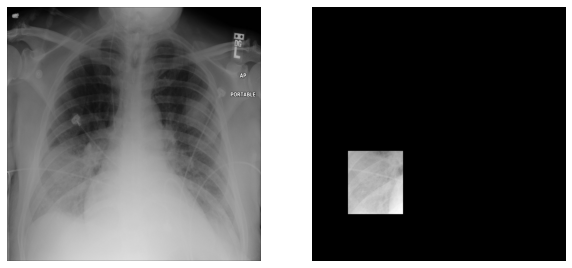

In [ ]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

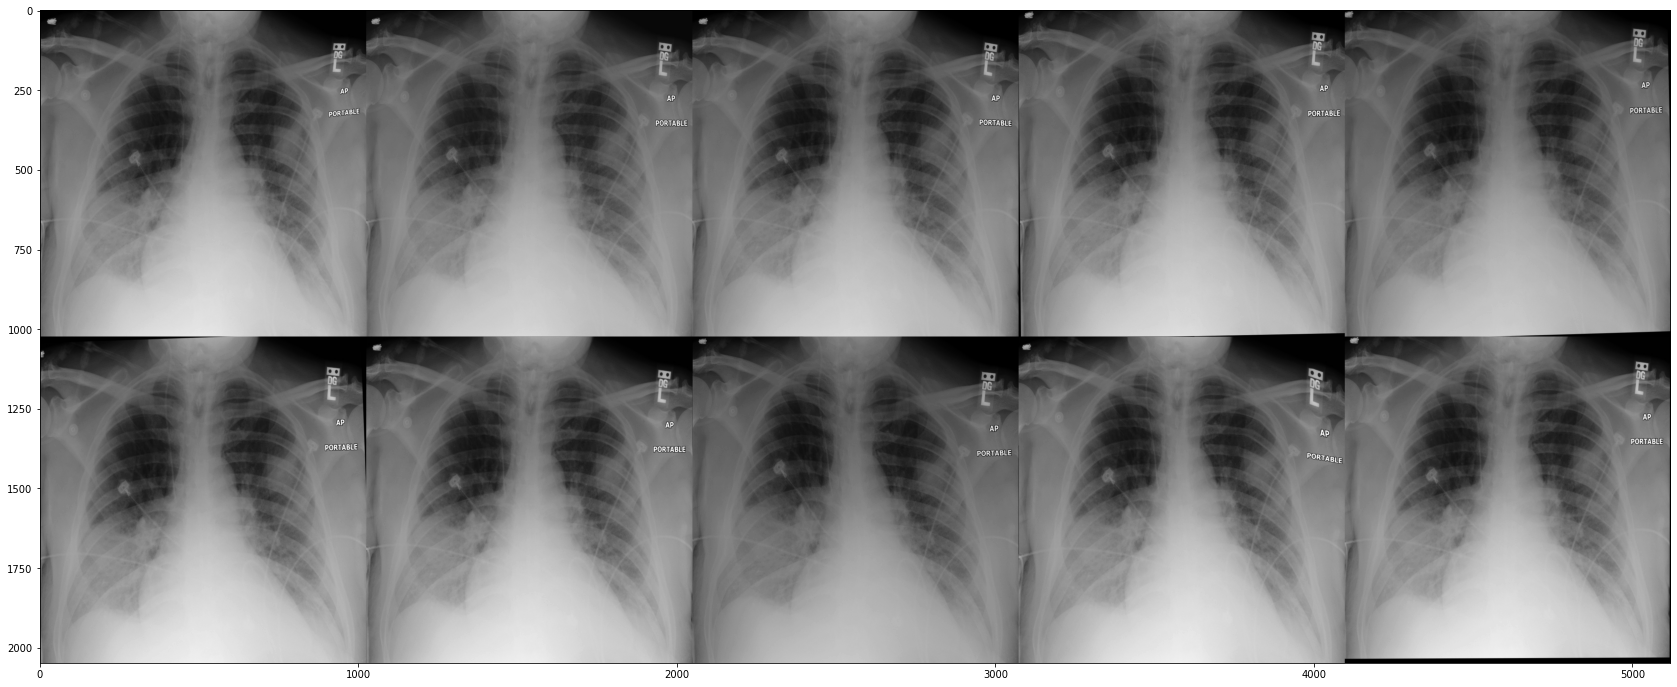

In [ ]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [ ]:
import tensorflow as tf

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model_path = os.path.join(ROOT_DIR,'pneumonia20200403T1606','mask_rcnn_pneumonia_0005.h5')
model.load_weights(model_path, by_name=True)
# Exclude the last layers because they require a matching
# number of classes
#model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
#    "mrcnn_class_logits", "mrcnn_bbox_fc",
#    "mrcnn_bbox", "mrcnn_mask"])







Re-starting from epoch 5


In [ ]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history
#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 5. LR=0.006

Checkpoint Path: /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=0.0012000000000000001

Checkpoint Path: /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.896812,0.020895,0.563333,0.274387,0.466167,0.572003,1.734651,0.015519,0.450573,0.276556,0.421853,0.570123
2,1.719890,0.014800,0.495224,0.244570,0.399876,0.565393,1.510334,0.013004,0.324554,0.238531,0.377432,0.556785
3,1.570478,0.012411,0.390270,0.221032,0.391254,0.555483,1.512136,0.012147,0.342699,0.236995,0.371864,0.548404
4,1.536754,0.011391,0.360689,0.206757,0.397220,0.560670,1.514043,0.011057,0.339233,0.222033,0.383419,0.558274
5,1.509812,0.011133,0.403378,0.181801,0.362012,0.551461,1.433283,0.009945,0.304117,0.209657,0.366895,0.542642
6,1.459875,0.009724,0.361474,0.175826,0.362073,0.550753,1.405371,0.009601,0.305044,0.195992,0.348432,0.546275
7,1.499732,0.010317,0.380088,0.210638,0.362082,0.536580,1.434034,0.009525,0.313852,0.212136,0.364332,0.534162
8,1.472000,0.009160,0.325502,0.217770,0.363929,0.555611,1.432510,0.008407,0.296959,0.227374,0.356452,0.543290
9,1.569569,0.011841,0.469380,0.178965,0.364714,0.544642,1.351759,0.008022,0.276089,0.190089,0.342010,0.535522
10,1.499533,0.009556,0.382351,0.208477,0.358729,0.540393,1.397775,0.008314,0.282521,0.220436,0.341938,0.544539


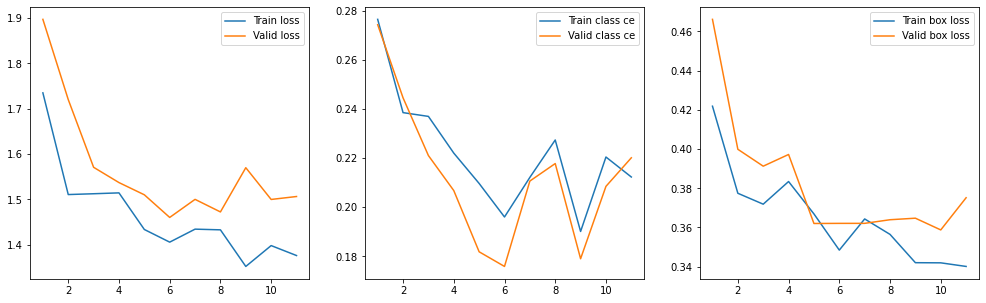

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 6 1.4598753786087035


In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
print(dir_names)
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = '/content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_0016.h5'
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_0016.h5
Re-starting from epoch 16


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


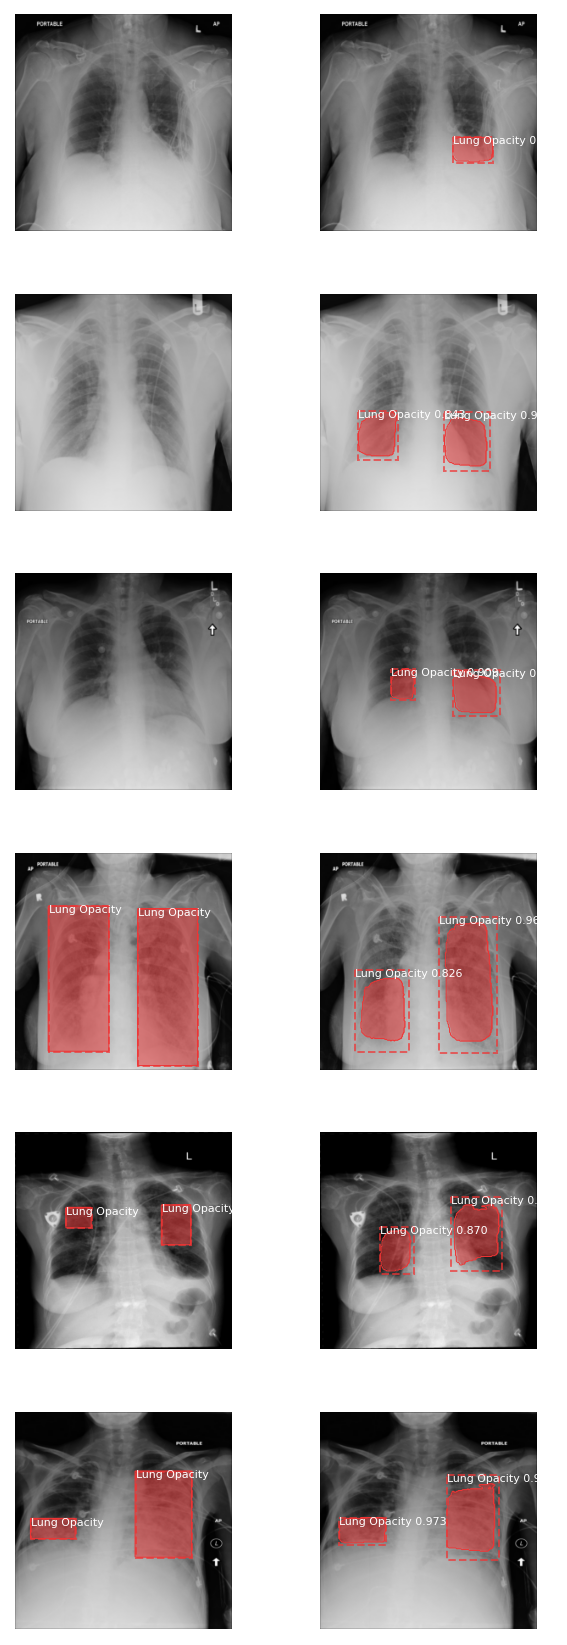

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [ ]:
from mrcnn.model import mold_image
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from matplotlib import pyplot

from matplotlib.patches import Rectangle

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
  # load image and mask
  for i in range(n_images):
    # load the image and mask
    image = dataset.load_image(i)
    mask, _ = dataset.load_mask(i)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # define subplot
    pyplot.figure(figsize=(15,15))
    pyplot.subplot(n_images, 2, i*2+1)
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Actual')
    # plot masks
    for j in range(mask.shape[2]):
      pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    # get the context for drawing boxes
    pyplot.subplot(n_images, 2, i*2+2)
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Predicted')
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
      # get coordinates
      y1, x1, y2, x2 = box
      # calculate width and height of the box
      width, height = x2 - x1, y2 - y1
      # create the shape
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      # draw the box
      ax.add_patch(rect)
  # show the figure
  pyplot.show()

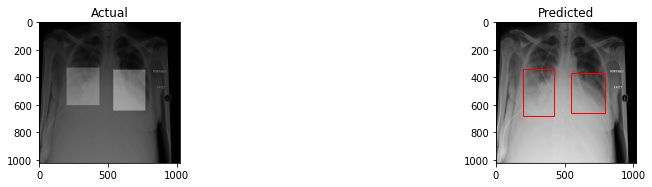

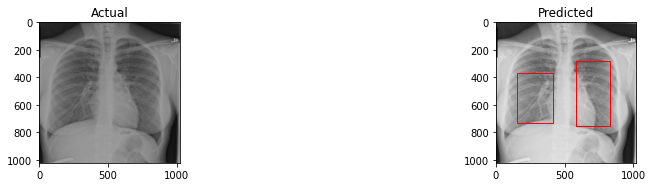

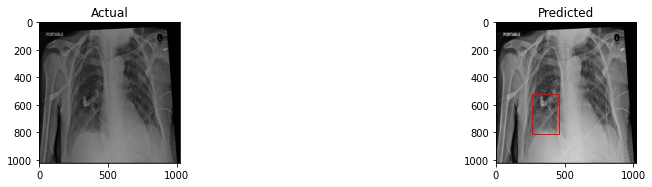

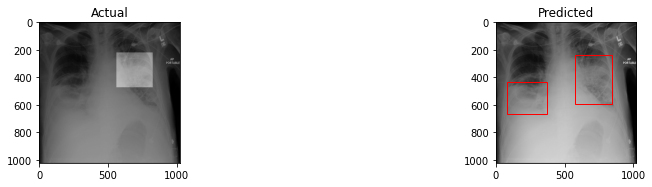

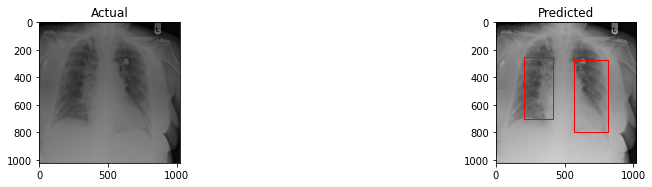

In [ ]:
# plot predictions for train dataset
plot_actual_vs_predicted(dataset_train, model, config)

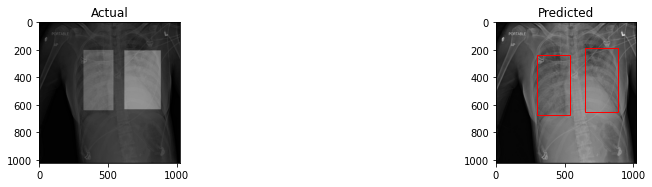

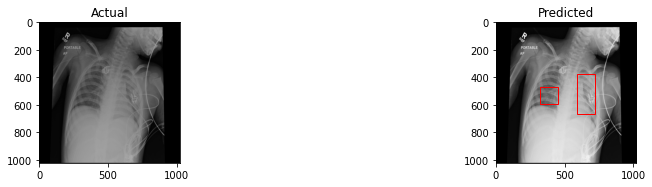

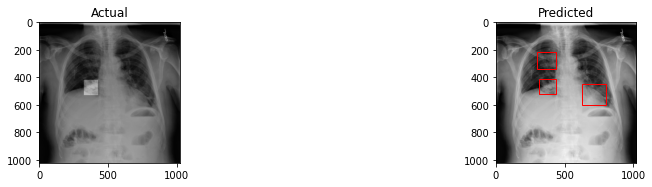

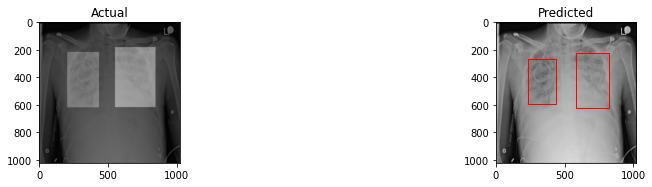

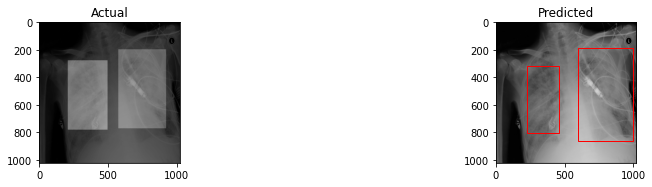

In [ ]:
# plot predictions for test dataset
plot_actual_vs_predicted(dataset_val, model, config)

In [ ]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
  APs = list()
  AaPs = list()
  for image_id in dataset.image_ids:
    # load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    #print(image_id)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    #print(r["class_ids"],len(r["class_ids"]),gt_class_id,len(gt_class_id))
    #print()
    if ((len(gt_class_id) > 0)):
      if ((len(r["class_ids"]) > 0)):
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'],0.2)
        AaPs.append(AP)
      else:
        AP=0.0
      # store
      #print(AP)
      APs.append(AP)
  # calculate the mean AP across all images
  mAP = mean(APs)
  mAPa = mean(AaPs)
  return mAP,mAPa

In [ ]:
# calculate the for a model on a given dataset
def evaluate_record_model(dataset, model, cfg):
  rcd=1
  # Creating an empty Dataframe with column names only
  dfObj = pd.DataFrame(columns=['patientId', 'rois','masks', 'class_ids', 'class_names', 'scores','original_val'])
  for image_id in dataset.image_ids:
    if rcd%100 == 0:
      print("record processed ---",rcd)
    rcd=rcd+1
    # load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    #print(image_id,dataset.image_reference(image_id))
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    patient_id = os.path.splitext(os.path.basename(dataset.image_reference(image_id)))[0]
    target_val=anns[ anns.patientId == patient_id].Target.unique()[0]
    # calculate statistics, including AP
    dfObj = dfObj.append({'patientId':patient_id, 'rois':r['rois'],'masks':r['masks'], 'class_ids':r['class_ids'], 'class_names':'penumonia', 'scores':r['scores'],'original_val':target_val}, ignore_index=True)
  return dfObj

In [ ]:
# predictions for test dataset %
data_val_df = evaluate_record_model(dataset_val, model, config)

In [ ]:
# Confustion matrix for reference
data_val_df['predicted_val'] = data_val_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions = data_val_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of test \n",predictions)
#predictions_matrix = predictions.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.sum()))

Confusion matrix of test 
                             class_ids
predicted_val original_val           
0             0                    10
              1                     1
1             0                   595
              1                   894


In [ ]:
# predictions for train dataset %
data_train_df = evaluate_record_model(dataset_train, model, config)

In [ ]:
# Confustion matrix for reference
data_train_df['predicted_val'] = data_train_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions_train = data_train_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of train \n",predictions_train)

Confusion matrix of train 
                             class_ids
predicted_val original_val           
0             0                    15
              1                     3
1             0                  1860
              1                  2790


In [ ]:
print("train accuracy",data_train_df[(data_train_df['predicted_val'] == data_train_df['original_val'])].class_ids.count()/(data_train_df.class_ids.count()) *100)

train accuracy 60.08997429305912


In [ ]:
print("test accuracy",data_val_df[(data_val_df['predicted_val'] == data_val_df['original_val'])].class_ids.count()/(data_val_df.class_ids.count()) *100)

test accuracy 60.266666666666666


In [ ]:
# predictions for train dataset mAP
train_mAP,train_mAPa = evaluate_model(dataset_train, model, config)
print("Train mAP",train_mAP,train_mAPa)

Train mAP 0.9058061827444095 0.9067801678871454


In [ ]:
# predictions for test dataset mAP
val_mAP,val_mAPa = evaluate_model(dataset_val, model, config)
print("Test mAP",val_mAP,val_mAPa)

Test mAP 0.8918994421621497 0.8928970925448814


In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model_path = os.path.join(ROOT_DIR,'pneumonia20200403T1606','mask_rcnn_pneumonia_0016.h5')
model.load_weights(model_path, by_name=True)

Re-starting from epoch 16


In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/10,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 16. LR=0.0006000000000000001

Checkpoint Path: /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.896812,0.020895,0.563333,0.274387,0.466167,0.572003,1.734651,0.015519,0.450573,0.276556,0.421853,0.570123
2,1.719890,0.014800,0.495224,0.244570,0.399876,0.565393,1.510334,0.013004,0.324554,0.238531,0.377432,0.556785
3,1.570478,0.012411,0.390270,0.221032,0.391254,0.555483,1.512136,0.012147,0.342699,0.236995,0.371864,0.548404
4,1.536754,0.011391,0.360689,0.206757,0.397220,0.560670,1.514043,0.011057,0.339233,0.222033,0.383419,0.558274
5,1.509812,0.011133,0.403378,0.181801,0.362012,0.551461,1.433283,0.009945,0.304117,0.209657,0.366895,0.542642
6,1.459875,0.009724,0.361474,0.175826,0.362073,0.550753,1.405371,0.009601,0.305044,0.195992,0.348432,0.546275
7,1.499732,0.010317,0.380088,0.210638,0.362082,0.536580,1.434034,0.009525,0.313852,0.212136,0.364332,0.534162
8,1.472000,0.009160,0.325502,0.217770,0.363929,0.555611,1.432510,0.008407,0.296959,0.227374,0.356452,0.543290
9,1.569569,0.011841,0.469380,0.178965,0.364714,0.544642,1.351759,0.008022,0.276089,0.190089,0.342010,0.535522
10,1.499533,0.009556,0.382351,0.208477,0.358729,0.540393,1.397775,0.008314,0.282521,0.220436,0.341938,0.544539


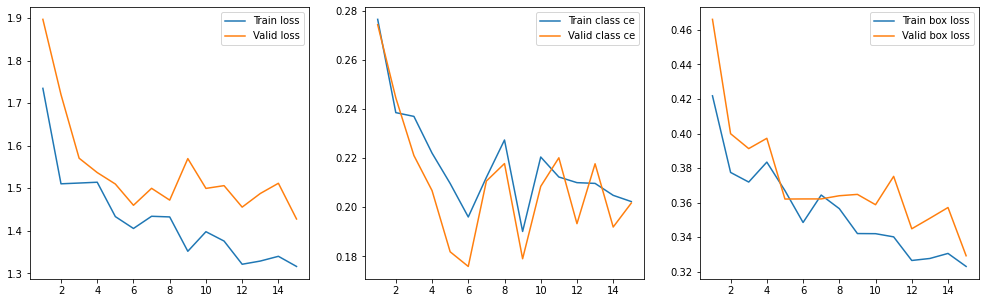

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = '/content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_0020.h5'
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_0020.h5
Re-starting from epoch 20


In [ ]:
# predictions for test dataset %
data_val_df = evaluate_record_model(dataset_val, model, config)

record processed --- 100
record processed --- 200
record processed --- 300
record processed --- 400
record processed --- 500
record processed --- 600
record processed --- 700
record processed --- 800
record processed --- 900
record processed --- 1000
record processed --- 1100
record processed --- 1200
record processed --- 1300
record processed --- 1400
record processed --- 1500


In [ ]:
# Confustion matrix for reference
data_val_df['predicted_val'] = data_val_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions = data_val_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of test \n",predictions)
#predictions_matrix = predictions.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.sum()))

Confusion matrix of test 
                             class_ids
predicted_val original_val           
0             0                    21
1             0                   584
              1                   895


In [ ]:
# predictions for train dataset %
data_train_df = evaluate_record_model(dataset_train, model, config)

record processed --- 100
record processed --- 200
record processed --- 300
record processed --- 400
record processed --- 500
record processed --- 600
record processed --- 700
record processed --- 800
record processed --- 900
record processed --- 1000
record processed --- 1100
record processed --- 1200
record processed --- 1300
record processed --- 1400
record processed --- 1500
record processed --- 1600
record processed --- 1700
record processed --- 1800
record processed --- 1900
record processed --- 2000
record processed --- 2100
record processed --- 2200
record processed --- 2300
record processed --- 2400
record processed --- 2500
record processed --- 2600
record processed --- 2700
record processed --- 2800
record processed --- 2900
record processed --- 3000
record processed --- 3100
record processed --- 3200
record processed --- 3300
record processed --- 3400
record processed --- 3500
record processed --- 3600
record processed --- 3700
record processed --- 3800
record processed --- 

In [ ]:
# Confustion matrix for reference
data_train_df['predicted_val'] = data_train_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions = data_train_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of train \n",predictions)
#predictions_matrix = predictions.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.sum()))

Confusion matrix of train 
                             class_ids
predicted_val original_val           
0             0                    65
              1                     2
1             0                  1810
              1                  2791


In [ ]:
print("train accuracy",data_train_df[(data_train_df['predicted_val'] == data_train_df['original_val'])].class_ids.count()/(data_train_df.class_ids.count()) *100)

train accuracy 61.18251928020566


In [ ]:
print("test accuracy",data_val_df[(data_val_df['predicted_val'] == data_val_df['original_val'])].class_ids.count()/(data_val_df.class_ids.count()) *100)

test accuracy 61.06666666666667


In [ ]:
# predictions for train dataset mAP
train_mAP,train_mAPa = evaluate_model(dataset_train, model, config)
print("Train mAP",train_mAP,train_mAPa)

Train mAP 0.9092970528157575 0.9099486451144431


In [ ]:
# predictions for test dataset mAP
val_mAP,val_mAPa = evaluate_model(dataset_val, model, config)
print("Test mAP",val_mAP,val_mAPa)

Test mAP 0.8960893863905741 0.8960893863905741


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


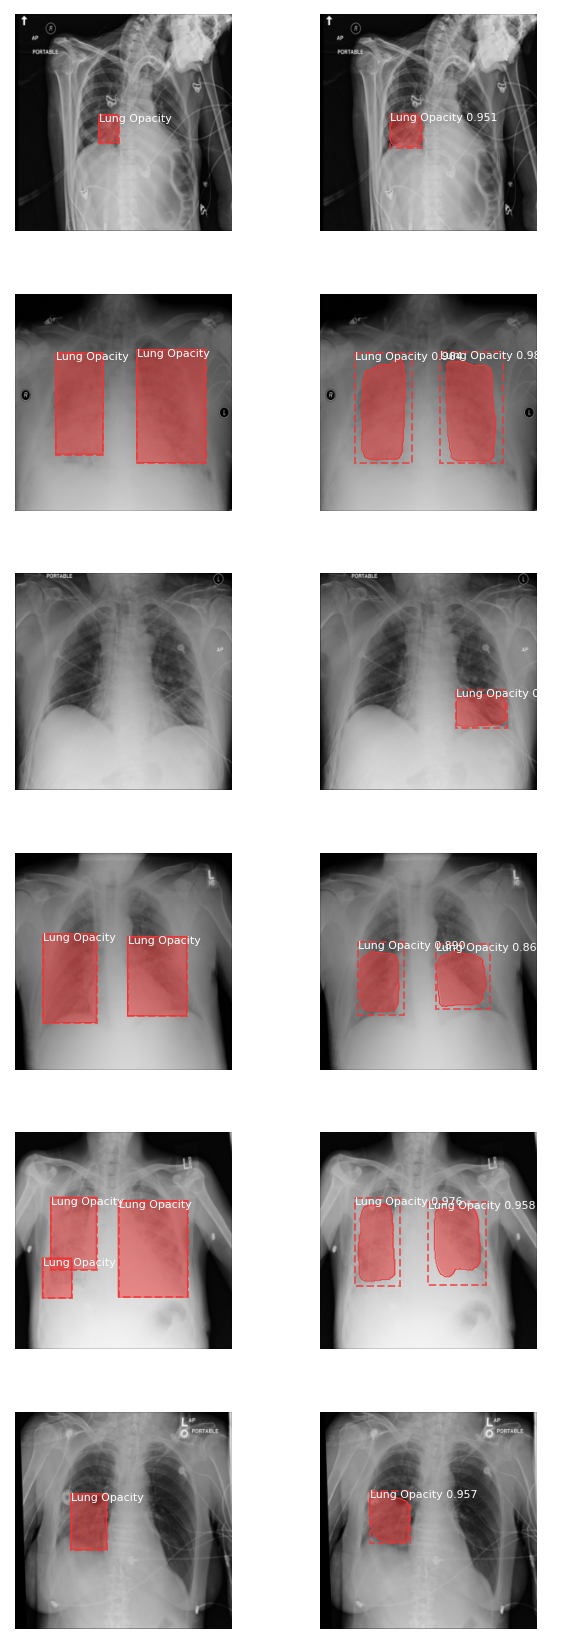

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

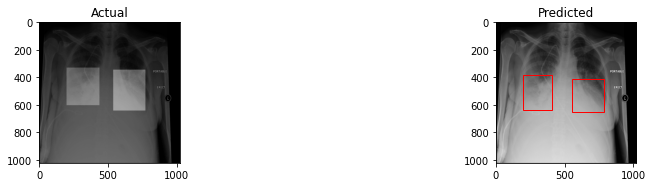

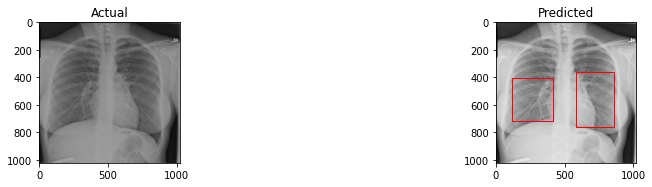

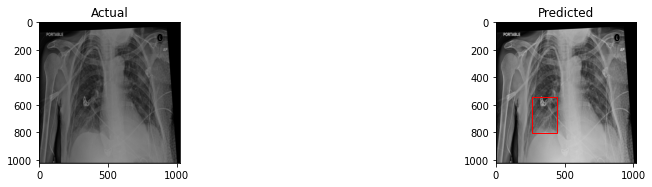

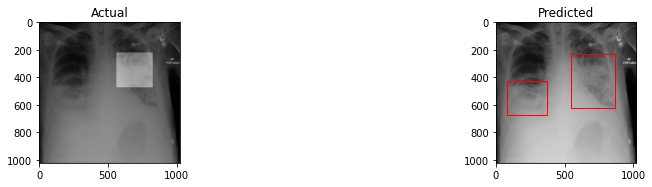

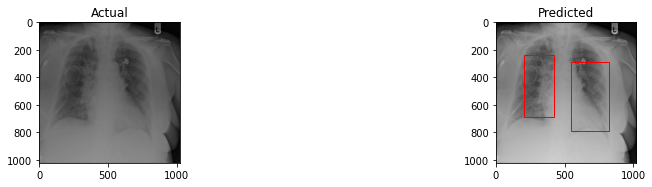

In [ ]:
# plot predictions for train dataset
plot_actual_vs_predicted(dataset_train, model, config)

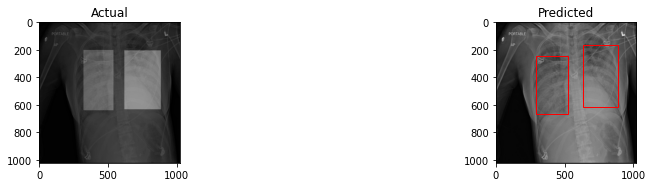

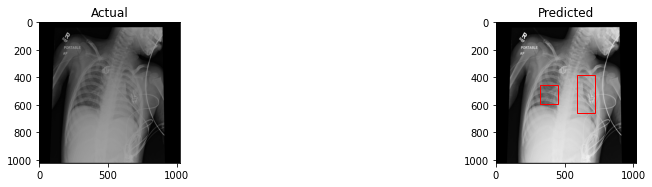

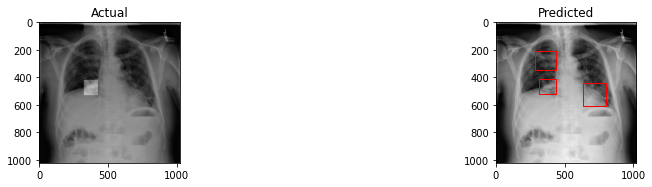

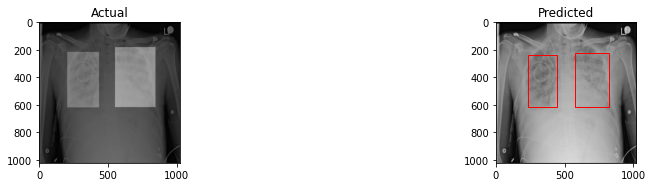

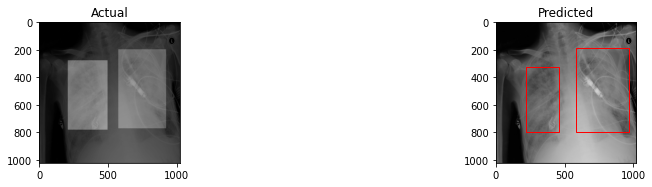

In [ ]:
# plot predictions for test dataset
plot_actual_vs_predicted(dataset_val, model, config)

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model_path = os.path.join(ROOT_DIR,'pneumonia20200403T1606','mask_rcnn_pneumonia_0020.h5')
model.load_weights(model_path, by_name=True)

Re-starting from epoch 20


In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/50,
            epochs=30,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.00012

Checkpoint Path: /content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = '/content/drive/My Drive/covid-19/Results/pneumonia20200403T1606/mask_rcnn_pneumonia_0030.h5'
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# predictions for test dataset %
data_val_df = evaluate_record_model(dataset_val, model, config)

In [ ]:
# Confustion matrix for reference
data_val_df['predicted_val'] = data_val_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions = data_val_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of test \n",predictions)
#predictions_matrix = predictions.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.sum()))

In [ ]:
# predictions for train dataset %
data_train_df = evaluate_record_model(dataset_train, model, config)

In [ ]:
# Confustion matrix for reference
data_train_df['predicted_val'] = data_train_df.class_ids.apply(lambda x : 1 if len(x) > 0 else 0)
predictions = data_train_df.groupby(['predicted_val','original_val']).agg({'class_ids': 'count'})
print("Confusion matrix of train \n",predictions)
#predictions_matrix = predictions.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.sum()))